<a href="https://colab.research.google.com/github/bryaanabraham/Nokia-Ideathon/blob/main/Path%20Analysis/Basic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path Analysis and Path_id Detection

In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import folium
import random
import time
from geopy.distance import geodesic
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from statistics import mode

Dataset includes longitude and latitude values which is used to train a model for path prediction

In [254]:
coords = pd.read_csv("Coordinates.csv")
coords = coords.dropna(how='all')
coords.head()

,latitude,longitude,path_id,danger_metric,weather_sensitivity
0,12.819391,80.039350,1.0,0.0,4.0
1,12.819807,80.038250,1.0,4.0,1.0
2,12.820105,80.037061,1.0,2.0,2.0
3,12.819367,80.036577,1.0,2.0,3.0
4,12.818376,80.035731,1.0,2.0,5.0


Visual Representation of all data points with a scatter plot

In [255]:
coords.tail()

,latitude,longitude,path_id,danger_metric,weather_sensitivity
94,12.774042,80.012670,2.0,3.0,3.0
95,12.774320,80.011681,2.0,2.0,5.0
96,12.774402,80.011073,2.0,1.0,1.0
97,12.774018,80.011729,2.0,0.0,0.0
98,12.773786,80.012908,2.0,0.0,4.0


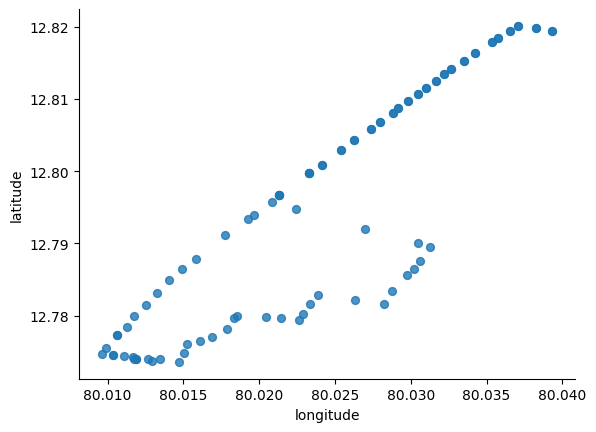

In [256]:
coords.plot(kind='scatter', y='latitude', x='longitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

A list of data frames is made to seperate each path taken on the basis of 'path_id' attribute

In [257]:
path = []
for i in range(1,len(coords['path_id'].unique())+1):
    path.append(coords[coords['path_id'] == i])

Visual Representation of Individual paths on a Folium Map

In [258]:
maps = []

max_lat = max(coords['latitude'])
min_lat = min(coords['latitude'])
min_lon = min(coords['longitude'])
max_lon = max(coords['longitude'])

n = len(coords['path_id'].unique())

# each path_id has its own map
for i in range(0,n):

  m = folium.Map()
  gps_path = list(zip(path[i-1]['latitude'], path[i-1]['longitude']))
  folium.PolyLine(locations=gps_path, color='blue', weight=2.5, opacity=0.8).add_to(m)
  folium.Marker(gps_path[20], icon=folium.Icon(color='blue'), popup=f'Known Path').add_to(m)

  m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])
  maps.append(m)

  display(maps[i])


Model for predicting path taken is made to predict which path is taken based on the current coordinate values. Model is trained on the 'training' dataset <br>X represents the feautures i.e. longitude and latitude<br>y represents the target variable that is path_id<br>Constraint: Accuracy is low due to overlapping paths

In [259]:
coords.columns

Index(['latitude', 'longitude', 'path_id', 'danger_metric',
       'weather_sensitivity'],
      dtype='object')

In [260]:
X = coords.drop(columns=['path_id', 'danger_metric', 'weather_sensitivity'])
y = coords['path_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

n = len(coords['path_id'].unique())

for i in range(n):
  new_X = path[i-1].drop(columns=['path_id', 'danger_metric', 'weather_sensitivity'])
  predicted_path_ids = model.predict(new_X)

  print(f"Predicted Paths IDs for path '{i+1}':", end=": ")
  for path_id in predicted_path_ids:
      print(path_id, end = ", ")
  print()
  mode_path_id = mode(predicted_path_ids)
  print(f"Mode of Predicted Paths: {mode_path_id:.0f}", end = "\n\n")

Accuracy: 0.45
Predicted Paths IDs for path '1':: 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 
Mode of Predicted Paths: 2

Predicted Paths IDs for path '2':: 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
Mode of Predicted Paths: 1



Function to determine the perpendicular distance of current coordinate from the closest point on the predited path<br>The ML model will predict the 'path_id' based on current coordinates. To determine the deviation from the path, the distance between the current coordinate and closest point to that coordinate on the predicted path is calculated.

In [261]:
def distance(current_point, coords_path):
    nearest_point_on_line = min(coords_path, key=lambda point: geodesic(point, current_point).meters)
    return geodesic(current_point, nearest_point_on_line).meters

Assigns colour based on deviation from path<br>In case of incoming data blue colour is used

In [262]:
def assign_color(distance, flag):
  if flag == False:
    if distance <= 15:
        return 'green'
    elif distance >= 25:
        return 'red'
    else:
        return 'orange'
  elif flag == True:
    return 'blue'

List of colours who's index represent a specific 'path_id'

In [263]:
colors = [' ','teal','red','green','purple','black','brown','maroon','navy','olive','aqua']

Demo of pseudo real time implementation<br>ML model is predicting the path taking the 'testing' dataset as input.

In [281]:
max_lat = max(coords['latitude'])
min_lat = min(coords['latitude'])
min_lon = min(coords['longitude'])
max_lon = max(coords['longitude'])

flag = False

l = len(path)
for j in range(l):
  m = folium.Map()
  input_coords = []
  n = len(path[j]) - 1
  for i in range(0, n, 2):
    input_data =path[j].iloc[[i]].drop(columns=['path_id', 'danger_metric', 'weather_sensitivity'])
    predicted_path_ids = model.predict(input_data)
    prediction = int(predicted_path_ids[0])

    lat = input_data['longitude'].values[0]
    lon = input_data['latitude'].values[0]
    input_coords.append((lon,lat))

    coords_path = list(zip(path[j]['latitude'],path[j]['longitude']))
    folium.PolyLine(locations=coords_path, color='blue', weight=2.5, opacity=0.4).add_to(m)

    input_path = input_coords
    folium.PolyLine(locations=input_path, color=colors[prediction], weight=3, opacity=0.8).add_to(m)

    current_point = (input_data['latitude'].values[-1],input_data['longitude'].values[-1])
    deviation = distance(current_point, coords_path)

    color = assign_color(deviation,flag)
    folium.Marker(location=current_point,
                  popup=f"Deviation: {deviation*1000:.2f} m\nPath_id: {prediction}",
                  icon=folium.Icon(color=color)).add_to(m)

    print(f"Predicted Path_id: {prediction}")
    print(f"True Path_id: {j+1}")
    m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])
    display(m)
    if i != n:
          children_copy = list(m._children.values())
          for child in children_copy:
              if isinstance(child, folium.features.PolyLine):
                  m._children.pop(child.get_name())
    if i == n:
      del m
    # time.sleep(1)


# Rule based voice assistant

In [265]:
## uncomment this at first run
# !pip install gtts

[Reference](https://stackoverflow.com/questions/57563060/how-to-do-text-to-speech-conversion-in-google-colab#:~:text=from%20gtts%20import%20gTTS%20%23Import,converted%20to%20speech%20as%20a%20.)

In [266]:
from gtts import gTTS
from IPython.display import Audio, display

tts = gTTS("You are taking an unknown path, are you sure you want to continue? ")
tts.save('unknow_path.wav')


In [267]:
# !rm temp.wav

# Adding an unexplored path to the dataset

New path is included to check for devaition from path leading to addition of path to data base

In [268]:
df = pd.read_csv("new-path.csv")

Visualization of new path

In [269]:
max_lon = max(df['longitude'])
min_lon = min(df['longitude'])
min_lat = min(df['latitude'])
max_lat = max(df['latitude'])

m = folium.Map()
gps_decoy_path = list(zip(df['latitude'], df['longitude']))
folium.PolyLine(locations=gps_decoy_path, color='red', weight=2.5, opacity=0.8).add_to(m)
m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])
m

Model is executed with coordinates from the new path as input and a prediction is made along with deviation analysis.<br>In case of increasing deviation in large amounts the model user is prompted regarding a possibility of a new path being taken.<br>If the user allows the path it will be added to the database and model will be retrained with the new path.

In [272]:
max_lat = max(df['latitude'])
min_lat = min(df['latitude'])
min_lon = min(df['longitude'])
max_lon = max(df['longitude'])

flag = False
red_count = 0

m = folium.Map()
input_coords = []

for i in range(len(df)):
  lat = df['latitude'][i]
  lon = df['longitude'][i]
  input_coords.append((lat,lon))

  predicted_path_ids = model.predict((input_coords))
  prediction = int(predicted_path_ids[0])
  print(prediction)
  coords_path = list(zip(path[prediction-1]['latitude'], path[prediction-1]['longitude']))
  folium.PolyLine(locations=coords_path, color='blue', weight=2.5, opacity=0.4).add_to(m)

  folium.PolyLine(locations=input_coords, color=colors[prediction], weight=2.5, opacity=0.8).add_to(m)

  current_point = (lat,lon)
  deviation = distance(current_point, coords_path)
  color = assign_color(deviation, flag)

  folium.Marker(location=current_point,
              popup=f"Deviation: {deviation:.2f} m\nPath_id: {prediction}",
              icon=folium.Icon(color=color)).add_to(m)

  print(f"Predicted Path_id: {prediction}")

  m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])
  display(m)
  if color == 'red' and flag == False:
    if prev_deviation is not None and deviation > prev_deviation:
      red_count += 1
      if red_count >= 2:
        sound_file = 'unknow_path.wav'
        display(Audio(sound_file, autoplay=True))
        user_input = input("You are taking an unknown path, are you sure you want to continue? ")
        if user_input.lower() == 'y':
          flag = True
        else:
          break
    else:
          red_count = 0

  prev_deviation = deviation
  # time.sleep(1)

The coordinate values of the new path are stored in a list by the name of 'input_coords' which is converted to a dataframe to be included in the list of paths.<br>'path_id' values is set accordingly.

In [273]:
input_coords_df = pd.DataFrame(input_coords, columns=['latitude', 'longitude'])
input_coords_df['path_id'] = len(path)+1
input_coords_df['danger_metric'] = 10
input_coords_df['weather_sensitivity'] = 10

In [274]:
input_coords_df.tail()

,latitude,longitude,path_id,danger_metric,weather_sensitivity
78,12.820981,80.041335,3,10,10
79,12.820597,80.041217,3,10,10
80,12.820597,80.041217,3,10,10
81,12.819331,80.040006,3,10,10
82,12.819477,80.039353,3,10,10


Dataframe is appended to the path (i.e a list of dataframes containing coordinate values of each path_id at seperate indexes)

In [275]:
path.append(input_coords_df)

The list of dataframes is concatenated into one dataframe 'concat_coords' to retrain the model over the new_path

In [276]:
concat_coords = pd.concat(path, ignore_index=True)

Model is trained in the same manner as above with concat_coords dataframe

In [277]:
X = concat_coords.drop(columns=['path_id', 'danger_metric','weather_sensitivity'])
y = concat_coords['path_id']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

n = len(concat_coords['path_id'].unique())

for i in range(n):
  new_X = path[i].drop(columns=['path_id', 'danger_metric','weather_sensitivity']).dropna()
  predicted_path_ids = model.predict(new_X)

  print(f"Predicted Paths IDs for path '{i+1}':", end=": ")
  for path_id in predicted_path_ids:
      print(path_id, end = ", ")
  print()
  mode_path_id = mode(predicted_path_ids)
  print(f"Mode of Predicted Paths: {mode_path_id:.0f}", end = "\n\n")

Accuracy: 0.2972972972972973
Predicted Paths IDs for path '1':: 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
Mode of Predicted Paths: 1

Predicted Paths IDs for path '2':: 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 1.0, 3.0, 
Mode of Predicted Paths: 2

Predicted Paths IDs for path '3':: 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0

Model is executed and deviation analysis is conducted over the new path coordinates to verify the functionality of the model after retraining

In [280]:
max_lat = max(df['latitude'])
min_lat = min(df['latitude'])
min_lon = min(df['longitude'])
max_lon = max(df['longitude'])

flag = False
red_count = 0

m = folium.Map()
input_coords = []

for i in range(len(df)):
  lat = df['latitude'][i]
  lon = df['longitude'][i]
  input_coords.append((lon, lat))

  predicted_path_ids = model.predict((input_coords))
  prediction = int(predicted_path_ids[0])
  coords_path = list(zip(path[prediction-1]['latitude'],path[prediction-1]['longitude']))
  folium.PolyLine(locations=coords_path, color='blue', weight=2.5, opacity=0.4).add_to(m)

  folium.PolyLine(locations=input_coords, color=colors[prediction], weight=2.5, opacity=0.8).add_to(m)

  current_point = (lat, lon)
  deviation = distance(current_point, coords_path)
  color = assign_color(deviation, flag)

  folium.Marker(location=current_point,
              popup=f"Deviation: {deviation:.2f} m\nPath_id: {prediction}",
              icon=folium.Icon(color=color)).add_to(m)

  print(f"Predicted Path_id: {prediction}")

  m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])
  display(m)

  if color == 'red' and flag == False:
    if prev_deviation is not None and deviation > prev_deviation:
      red_count += 1
      if red_count >= 2:
        sound_file = 'unknow_path.wav'
        display(Audio(sound_file, autoplay=True))
        user_input = input("You are taking an unknown path, are you sure you want to continue? ")
        if user_input.lower() == 'y':
          flag = True
        else:
          break
    else:
          red_count = 0

  prev_deviation = deviation
  # time.sleep(1)
